In [1]:
import os
import sys
import octomap
import datetime
import importlib
import numpy as np
import pandas as pd
from pathlib import Path
from pyquaternion import Quaternion
from nuscenes.nuscenes import NuScenes
from nuscenes.utils.data_classes import RadarPointCloud, LidarPointCloud
from nuscenes.utils.geometry_utils import transform_matrix

import repackage
repackage.up()
from utils.ransac_solver import RANSACSolver
from IPython.display import display
import os.path as osp
from functools import reduce
import matplotlib.pyplot as plt

import open3d as o3d
from tqdm import tqdm

RadarPointCloud.default_filters()

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


## Dataloader

In [2]:
def clear_z_one_pose(pose):
    output_pose = np.zeros((6,))
    state_vector = TransformMatrix4dToVector6d(pose)
    output_pose[:2] = state_vector[:2]
    output_pose[5] = state_vector[5]
    return TransformVector6dToMatrix4d(output_pose)

def clear_z(input_pose):
    output_poses = np.zeros((input_pose.shape[0], 4, 4))
    for i, pose in enumerate(input_pose):
        output_poses[i, :, :] = clear_z_one_pose(pose)
    return output_poses

def TransformMatrix4dToVector6d(H):
    x, y, z = H[0, 3], H[1, 3], H[2, 3]

    roll = np.arctan2(H[2, 1], H[2, 2])
    pitch = np.arctan2(-H[2, 0], np.sqrt(H[0, 0] * H[0, 0] + H[1, 0] * H[1, 0]))
    yaw = np.arctan2(H[1, 0], H[0, 0])

    v = np.array([x, y, z, roll, pitch, yaw], dtype=np.float64)

    return v


def TransformVector6dToMatrix4d(v):
    x, y, z, roll, pitch, yaw = v[0], v[1], v[2], v[3], v[4], v[5]

    cos_roll = np.cos(roll)
    sin_roll = np.sin(roll)
    cos_pitch = np.cos(pitch)
    sin_pitch = np.sin(pitch)
    cos_yaw = np.cos(yaw)
    sin_yaw = np.sin(yaw)

    # Construct the rotation matrix using Rodrigues' rotation formula.
    R_yaw = np.array([[cos_yaw, -sin_yaw, 0],
                      [sin_yaw, cos_yaw, 0],
                      [0, 0, 1]], dtype=np.float64)

    R_pitch = np.array([[cos_pitch, 0, sin_pitch],
                        [0, 1, 0],
                        [-sin_pitch, 0, cos_pitch]], dtype=np.float64)

    R_roll = np.array([[1, 0, 0],
                       [0, cos_roll, -sin_roll],
                       [0, sin_roll, cos_roll]], dtype=np.float64)

    R = np.dot(np.dot(R_yaw, R_pitch), R_roll)

    # Translation vector.
    T = np.array([x, y, z], dtype=np.float64)

    # Combine the rotation and translation to form the homogeneous matrix.
    T_matrix = np.eye(4)
    T_matrix[:3, :3] = R
    T_matrix[:3, 3] = T

    return T_matrix

def transform_points(transform, dpoints):
    # N x [x y z rcs v v_comp]
    result_dpoints = np.zeros_like(dpoints)

    points_h = np.ones((dpoints.shape[0], 4))
    points_h[:, :3] = dpoints[:, :3]
    points_h = (points_h @ transform.T)
    result_dpoints[:, :3] = points_h[:, :3]

    return result_dpoints


def transform_doppler_points(transform, dpoints):
    # N x [x y z rcs v v_comp]
    result_dpoints = np.zeros_like(dpoints)

    points_h = np.ones((dpoints.shape[0], 4))
    points_h[:, :3] = dpoints[:, :3]
    points_h = (points_h @ transform.T)
    result_dpoints[:, :3] = points_h[:, :3]

    if dpoints.shape[1] > 3:
        result_dpoints[:, 3:] = dpoints[:, 3:]

    return result_dpoints


def polar_to_cartesian(coordinates):
    # Convert degrees to radians
    azimuth = coordinates[:, 1]
    elevation = np.pi/2 - coordinates[:, 2]

    # Calculate Cartesian coordinates
    x = coordinates[:, 0] * np.sin(elevation) * np.cos(azimuth)
    y = coordinates[:, 0] * np.sin(elevation) * np.sin(azimuth)
    z = coordinates[:, 0] * np.cos(elevation)

    cartesian_coordinates = np.column_stack((x, y, z))
    return cartesian_coordinates


def transform_points_to_car_frame(points, calibs):
    transformed_points = []
    for i in range(points.shape[0]):
        point = points[i, :]
        sensor_idx = int(point[6])
        result_point = np.copy(point)
        point_homogeneous = np.ones(4)
        point_homogeneous[:3] = point[:3]
        T = calibs[sensor_idx]
        result_point[:3] = T.dot(point_homogeneous)[:3]
        transformed_points.append(result_point)
        
    return np.array(transformed_points)

In [3]:
class NuScenesDataloader:
    def __init__(self, nusc, data_dir: Path, sequence: int,  nusc_version: str = "v1.0-mini", *_, **__):
        try:
            importlib.import_module("nuscenes")
        except ModuleNotFoundError:
            print("nuscenes-devkit is not installed on your system")
            print('run "pip install nuscenes-devkit"')
            sys.exit(1)

        self.data_dir = data_dir
        self.sequence_id = str(int(sequence)).zfill(4)
        self.sequence = self.sequence_id

        if nusc is None:
            raise "No NuScenes dataset provided"
        
        self.nusc = nusc
        self.scene_name = f"scene-{self.sequence_id}"
        
        # Get the scene
        self.scene = None
        for s in self.nusc.scene:
           if self.scene_name == s["name"]:
               self.scene = s
        
        if  self.scene is None:
            print(f'[ERROR] Sequence "{self.sequence_id}" not available scenes')
            print("\nAvailable scenes:")
            self.nusc.list_scenes()
            sys.exit(1)

    @staticmethod
    def doppler_v(pts, vx_idx, vy_idx):
        # pts: [x y z dyn_prop id rcs vx vy vx_comp vy_comp ...]
        # Compute the Doppler shift for each point
        x, y, vx, vy = pts[:, 0], pts[:, 1], pts[:, vx_idx], pts[:, vy_idx]
        v_doppler = (vx*x + vy*y) / np.sqrt(x**2 + y**2)

        return v_doppler


In [4]:
class NuScenesMultipleRadarMultiSweeps(NuScenesDataloader):
    def __init__(self, 
                 nusc,
                 data_dir: Path,
                 sequence: int,
                 seq_crop_indices: list = [],
                 nsweeps = 5,
                 sensors: list= [],
                 filter_dynamic_pts=False,
                 sps_labels_dir=None,
                 sps_thresh=0.6,
                 apply_dpr = False,
                 ransac_threshold = 0.1,
                 ref_sensor='LIDAR_TOP',
                 ref_frame=None,
                 measure_range = 100,
                 nusc_version: str = "v1.0-mini",
                 annotated_keyframes: bool = False, *_, **__):
        """
        Initializer for the NuScenes Radar and LIDAR synchronized dataset

        Args:
            data_dir (Path): Location of the NuScenes dataset
            sequence (int): Sequence ID
            mode (str, optional): Do we want radar or LIDAR data?.  Defaults to "lidar".
            sensor_name (str, optional): Sensor name from the dataset: 
            front_only (bool, optional): Do we want only data from the front radar?
        """
        if len(sensors) == 0:
            raise ValueError("No sensors selected")
        super().__init__(nusc, data_dir, sequence, "radar", nusc_version)

        self.sensors = sensors
        self.ref_sensor = ref_sensor
        self.channels = ["RADAR_FRONT", "RADAR_FRONT_LEFT", "RADAR_FRONT_RIGHT", "RADAR_BACK_LEFT", "RADAR_BACK_RIGHT"]

        self.ref_frame = ref_frame

        self.seq_crop_indices = seq_crop_indices # Keep between of these frames only
        assert(nsweeps > 0), "Number of sweeps should be >= 1"
        self.n_sweeps = nsweeps
        self.measure_range = measure_range

        self.ransac_solver = RANSACSolver(ransac_threshold)
        self.apply_dpr = apply_dpr
        self.filter_dynamic_pts = filter_dynamic_pts
        self.sps_labels_dir = sps_labels_dir
        self.sps_thresh = sps_thresh
        self.min_distance = 1.0 # For Multi-sweep reading

        
        if annotated_keyframes:
            self.sensor_readings, self.num_readings = self._get_annotated_sensor_readings(self.sensors)
            self.cam_readings = self._get_annotated_sensor_readings(["CAM_FRONT"])[0]["CAM_FRONT"]
        else:
            self.sensor_readings, self.num_readings = self._get_sensor_readings()
        
        self.gt_poses = self._load_poses()
        self.local_poses = clear_z(self._load_poses(global_poses=False))
        self.global_poses = clear_z(self._load_poses(global_poses=True))
        self.timestamps = self._get_timestamps()[:len(self.gt_poses)]
        
        self.frame_data, self.valid_sample_tokens, self.valid_frame_indices  = self._read_frames_multisweeps()
        
        self.gt_poses = [p for i,p in enumerate(self.gt_poses) if i in self.valid_frame_indices]
        self.local_poses = [p for i,p in enumerate(self.local_poses) if i in self.valid_frame_indices]
        self.global_poses = [p for i,p in enumerate(self.global_poses) if i in self.valid_frame_indices]
        self.timestamps = [p for i,p in enumerate(self.timestamps) if i in self.valid_frame_indices]
        self.gt_poses_global = np.array(self.global_poses)
        self.num_readings = len(self.valid_frame_indices)


        self.image_width = 1600
        self.image_height = 9000
        self.h_fov_deg = 70
        self.v_fov_deg = 44
        
        
        
    def __len__(self):
        return self.num_readings


    def __getitem__(self, idx):
        if self.ref_frame == self.ref_sensor and self.ref_frame is not None:
            sensors = [self.ref_sensor]
        else:
            sensors = self.sensors
        return self.read_point_clouds(idx), self.read_calibs(idx), sensors, self.read_timestamps(idx)
    
    
    def read_point_clouds(self, idx):
        pointclouds = []
        
        frame_dict = self.frame_data[idx]
        pcd = frame_dict['points']
        sensor_ids = frame_dict['sensor_ids']
        calibs = self.read_calibs(idx)
        global_from_car = self.global_poses[idx]

        parsed_points = None

        if self.ref_frame == self.ref_sensor and self.ref_frame is not None:
            # Just return the reference sensor pcd
            points = pcd[self.ref_sensor]
            pointcloud_reformatted = np.zeros((len(points), 6))
            pointcloud_reformatted[:, :3] = points[:, :3] # x y z
            pointcloud_reformatted[:, 3] = points[:, 3] # rcs
            pointcloud_reformatted[:, 4]   = self.doppler_v(points, 5, 6) # doppler_shift
            pointcloud_reformatted[:, 5]   = self.doppler_v(points, 7, 8) # compensated velocities doppler shift
            parsed_points = [pointcloud_reformatted.astype(np.float64)]
        elif self.ref_frame is None:
            # Output each pointcloud in its own sensor frame
            for sensor in self.sensors:
                points = pcd[sensor]
                pointcloud_reformatted = np.zeros((len(points), 6))
                pointcloud_reformatted[:, :3] = points[:, :3] # x y z
                pointcloud_reformatted[:, 3] = points[:, 3] # rcs
                pointcloud_reformatted[:, 4]   = self.doppler_v(points, 5, 6) # doppler_shift
                pointcloud_reformatted[:, 5]   = self.doppler_v(points, 7, 8) # compensated velocities doppler shift
                pointclouds.append(pointcloud_reformatted.astype(np.float64))
            parsed_points = pointclouds
        
        elif self.ref_frame == 'ego':
            # Transform pointcloud to the ego vehicle frame for each sensor and stack them
            for sensor, car_from_sensor in zip(self.sensors, calibs):
                points = pcd[sensor]
                pointcloud_reformatted = np.zeros((len(points), 6))
                pointcloud_reformatted[:, :3] = points[:, :3] # x y z
                pointcloud_reformatted[:, 3] = points[:, 3] # rcs
                pointcloud_reformatted[:, 4]   = self.doppler_v(points, 5, 6) # doppler_shift
                pointcloud_reformatted[:, 5]   = self.doppler_v(points, 7, 8) # compensated velocities doppler shift
                ego_points = transform_doppler_points(car_from_sensor, pointcloud_reformatted.astype(np.float64))
                pointclouds.append(ego_points)
            parsed_points = np.vstack(pointclouds)
        elif self.ref_frame == 'global':
            for sensor, car_from_sensor in zip(self.sensors, calibs):
                points = pcd[sensor]
                pointcloud_reformatted = np.zeros((len(points), 6))
                pointcloud_reformatted[:, :3] = points[:, :3] # x y z
                pointcloud_reformatted[:, 3] = points[:, 3] # rcs
                pointcloud_reformatted[:, 4]   = self.doppler_v(points, 5, 6) # doppler_shift
                pointcloud_reformatted[:, 5]   = self.doppler_v(points, 7, 8) # compensated velocities doppler shift
                ego_points = transform_doppler_points(car_from_sensor, pointcloud_reformatted.astype(np.float64))
                global_points = transform_doppler_points(global_from_car, ego_points)
                pointclouds.append(global_points)
            parsed_points = np.vstack(pointclouds)

        if self.sps_labels_dir is not None:
            # Label and filter points
            labelled_map_path = os.path.join(self.sps_labels_dir, f'scene-{self.sequence_id}.asc')
            lmap = np.loadtxt(labelled_map_path, delimiter=' ', skiprows=1)

            def get_sps_labels(map, scan_points):
                labeled_map_points = map[:, :3]
                labeled_map_labels = map[:, -1]

                sps_labels = []
                for point in scan_points[:, :3]:
                    distances = np.linalg.norm(labeled_map_points - point, axis=1)
                    closest_point_idx = np.argmin(distances)
                    sps_labels.append(labeled_map_labels[closest_point_idx])
                sps_labels = np.array(sps_labels)
                return sps_labels

            if self.ref_frame is None:
                # Need to extract labels for each sensor's points 
                filtered_pcds = []
                for sensor in self.sensors:
                    s_idx = self.sensors.index(sensor)
                    sensor_pcd = parsed_points[s_idx]
                    ego_sensor_pcd = transform_doppler_points(calibs[s_idx], sensor_pcd)
                    global_sensor_pcd = transform_doppler_points(global_from_car, ego_sensor_pcd)
                    sensor_pcd_labels = get_sps_labels(lmap, global_sensor_pcd)
                    sps_filtered_pcd = sensor_pcd[sensor_pcd_labels >= self.sps_thresh]
                    # print(f"Before: {len(sensor_pcd)} | After {len(sps_filtered_pcd)}")
                    if len(sps_filtered_pcd) == 0:
                        filtered_pcds.append(sensor_pcd.astype(np.float64))
                    else:
                        filtered_pcds.append(sps_filtered_pcd.astype(np.float64))
                parsed_points = filtered_pcds

            elif self.ref_frame in self.sensors:
                s_idx = self.sensors.index(self.ref_frame)
                sps_filtered_pcd = parsed_points[s_idx]
                ego_sensor_pcd = transform_doppler_points(calibs[s_idx], sps_filtered_pcd)
                global_sensor_pcd = transform_doppler_points(global_from_car, ego_sensor_pcd)
                sps_labels = get_sps_labels(lmap, global_sensor_pcd)
                sps_filtered_pcd = sps_filtered_pcd[sps_labels >= self.sps_thresh]
                parsed_points = [sps_filtered_pcd.astype(np.float64)]

            elif self.ref_frame == 'ego':
                sps_filtered_pcd = parsed_points
                global_sensor_pcd = transform_doppler_points(global_from_car, sps_filtered_pcd)
                sps_labels = get_sps_labels(lmap, global_sensor_pcd)
                sps_filtered_pcd = sps_filtered_pcd[sps_labels >= self.sps_thresh]
                parsed_points = sps_filtered_pcd.astype(np.float64)
            
            elif self.ref_frame == 'global':
                sps_labels = get_sps_labels(lmap, parsed_points)
                sps_filtered_pcd = sps_filtered_pcd[sps_labels >= self.sps_thresh]
                parsed_points = sps_filtered_pcd.astype(np.float64)


        return parsed_points

    @staticmethod
    def filter_static_reliable_points(pointcloud):
        """
        Filters radar pointcloud data to keep the most reliable static points.
        
        :param pointcloud: <np.float: d, n>. Point cloud matrix with d dimensions and n points.
        :return: Filtered point cloud matrix.
        """
        
        # Define the states to keep
        invalid_states_to_keep = [0,4,8,9,10,11,12,15,16,17]
        dynprop_states_to_keep = [1, 3, 5, 7]
        ambig_states_to_keep = [3]
        
        # Extract relevant fields from the point cloud data
        dyn_prop = pointcloud[3, :]
        invalid_state = pointcloud[15, :]
        ambig_state = pointcloud[11, :]

        # Create a boolean mask for each condition
        mask_dynprop = np.isin(dyn_prop, dynprop_states_to_keep)
        mask_invalid = np.isin(invalid_state, invalid_states_to_keep)
        mask_ambig = np.isin(ambig_state, ambig_states_to_keep)
        
        # Combine masks to filter points that satisfy all conditions
        combined_mask = mask_dynprop & mask_invalid & mask_ambig
        # Filter the point cloud
        filtered_pointcloud = pointcloud[:, combined_mask]
        
        return filtered_pointcloud
    
    def _read_frames_multisweeps(self):
        """
        Reads radar data and processes it into frames.

        Args:
            merge_into_ref_sensor (bool): If True, merge data from all sensors into ref_sensor coordinate frame.
                                        If False, keep point clouds from each sensor separate.

        Returns:
            List of frames.
        """
        def process_sweeps(start_index, n_sweeps):
            current_frame = {}
            sensor_ids = []
            pcd_dict = {sensor: np.zeros((0, 10)) for sensor in self.channels}  # Dictionary to store point clouds for each sensor

            for sensor in self.channels:
                points = np.zeros((RadarPointCloud.nbr_dims(), 0))
                all_pc = RadarPointCloud(points)
                all_times = np.zeros((1, 0))

                if self.ref_sensor is None:
                    # Use the sensor itself
                    ref_chan = sensor
                else:
                    ref_chan = self.ref_sensor
                    
                ref_sample_data = self.sensor_readings[ref_chan][start_index]
                ref_time = 1e-6 * ref_sample_data['timestamp']
                ref_pose_rec = self.nusc.get('ego_pose', ref_sample_data['ego_pose_token'])
                ref_cs_rec = self.nusc.get('calibrated_sensor', ref_sample_data['calibrated_sensor_token'])
                ref_from_car = transform_matrix(ref_cs_rec['translation'], Quaternion(ref_cs_rec['rotation']), inverse=True)
                car_from_global = transform_matrix(ref_pose_rec['translation'], Quaternion(ref_pose_rec['rotation']), inverse=True)


                current_sample_data = self.sensor_readings[sensor][start_index]
                ext_nbr_points = []

                # print(f"Processing index: {start_index} | Sweep indices: ", end="")
                for j in range(n_sweeps):
                    current_index = start_index - j
                    if current_index < 0:
                        break

                    # print(current_index, end=", ")

                    # invalid_states_to_keep = [0x00, 0x04, 0x08, 0x09, 0x0a, 0x0b, 0x0c, 0x0f, 0x10, 0x11]
                    invalid_states_to_keep = [0,4,8,9,10,11,12,15,16,17]
                    dynprop_states_to_keep = [1, 3, 5, 7]
                    ambig_states_to_keep = [3]
                    if self.filter_dynamic_pts:
                        current_pc = RadarPointCloud.from_file(osp.join(self.nusc.dataroot,
                                                                        current_sample_data['filename']),
                                                                        invalid_states=invalid_states_to_keep,
                                                                        dynprop_states=dynprop_states_to_keep, ambig_states=ambig_states_to_keep)
                    else:
                        current_pc = RadarPointCloud.from_file(osp.join(self.nusc.dataroot,
                                                                        current_sample_data['filename']),
                                                                        invalid_states=range(18),
                                                                        dynprop_states=range(8), ambig_states=range(5))
                    current_pc.remove_close(self.min_distance)
                    

                    # Transform to reference channel
                    if self.ref_sensor is not None and self.ref_frame in self.sensors:
                        current_pose_rec = self.nusc.get('ego_pose', current_sample_data['ego_pose_token'])
                        global_from_car = transform_matrix(current_pose_rec['translation'], Quaternion(current_pose_rec['rotation']), inverse=False)
                        current_cs_rec = self.nusc.get('calibrated_sensor', current_sample_data['calibrated_sensor_token'])
                        car_from_current = transform_matrix(current_cs_rec['translation'], Quaternion(current_cs_rec['rotation']), inverse=False)
                        trans_matrix = reduce(np.dot, [ref_from_car, car_from_global, global_from_car, car_from_current])
                        current_pc.transform(trans_matrix)

                    time_lag = ref_time - 1e-6 * current_sample_data['timestamp']
                    times = time_lag * np.ones((1, current_pc.nbr_points()))
                    all_times = np.hstack((all_times, times))
                    all_pc.points = np.hstack((all_pc.points, current_pc.points))
                    ext_nbr_points.append(current_pc.points.shape[1])

                    if current_index > 0:
                        current_sample_data = self.sensor_readings[sensor][current_index]
                # print()
                radar_pc = all_pc
                times = all_times
                nbr_points = np.array(ext_nbr_points)

                ## Filter points
                # radar_pc = self.filter_static_reliable_points(radar_pc.points)
                radar_pc = radar_pc.points
                radar_points = np.zeros((9, radar_pc.shape[1]))
                
                radar_points[:3, :] = radar_pc[:3, :]
                radar_points[3, :] = radar_pc[5, :]
                radar_points[4, :] = radar_pc[4, :]
                radar_points[5:7, :] = radar_pc[6:8, :]
                radar_points[7:9, :] = radar_pc[8:10, :]
                radar_points = radar_points.T
                radar_points = np.hstack((radar_points, times.transpose()))

                if self.apply_dpr and radar_points.shape[0] > 1:
                    nbr_flag = np.cumsum(nbr_points)
                    pcl_list = np.split(radar_points, nbr_flag, axis=0)
                    pcls_new = np.zeros((0, 10))
                    for index, pcl in enumerate(pcl_list[:-1]):
                        if pcl.shape[0] > 1:
                            info = [
                                [self.sequence_id, current_index],
                                sensor,
                                nbr_points[0]
                            ]
                            best_mask, _, _ = self.ransac_solver.ransac_nusc(pcl, vis=False, info=info)
                            if best_mask is not None:
                                pcl = pcl[best_mask]
                        pcls_new = np.vstack((pcls_new, pcl))
                    radar_points = pcls_new

                pcd_dict[sensor] = np.concatenate((pcd_dict[sensor], radar_points), axis=0)
                sensor_ids.extend([sensor] * len(radar_points))

            pose = np.empty((4, 4), dtype=np.float32)
            pose_record = self.nusc.get("ego_pose", ref_sample_data["ego_pose_token"])
            pose[:, :] = transform_matrix(
                pose_record["translation"],
                Quaternion(pose_record["rotation"]),
            )

            current_frame = {
                'points': pcd_dict,
                'gt_pose': pose,
                'position': pose[:2, 3].reshape(1, -1),
                'timestamp': ref_sample_data['timestamp'],
                'sensor_ids': np.array(sensor_ids),
            }

            frames.append(current_frame)
            valid_indices.append(start_index)

        frames = []
        valid_indices = []
        valid_tokens = []

        # Process full sweeps
        for i in range(self.n_sweeps - 1, self.num_readings, self.n_sweeps):
            process_sweeps(i, self.n_sweeps)

        # Process remaining sweeps
        remaining = self.num_readings % self.n_sweeps
        if remaining > 0:
            process_sweeps(self.num_readings - 1, remaining)

        sorted_frames = sorted(frames, key=lambda t: t['timestamp'])
        frames = list(sorted_frames)
        for frame in frames:
            frame['day'] = (frame['timestamp'] - sorted_frames[0]['timestamp']) / (1e6 * 3600 * 24)
        return frames, valid_tokens, valid_indices


    def read_calibs(self, idx):
        if self.ref_frame == self.ref_sensor and self.ref_frame is not None:
            calib = self.nusc.get('calibrated_sensor', self.sensor_readings[self.ref_sensor][idx]['calibrated_sensor_token'])
            sensor_to_car = transform_matrix(calib['translation'], Quaternion(calib['rotation']), inverse=False)
            return [sensor_to_car]
        else:
            calibs = []
            for sensor in self.sensors:
                calib = self.nusc.get('calibrated_sensor', self.sensor_readings[sensor][idx]['calibrated_sensor_token'])
                sensor_to_car = transform_matrix(calib['translation'], Quaternion(calib['rotation']), inverse=False)
                calibs.append(sensor_to_car)
            
            return calibs
    

    def read_timestamps(self, idx):
        timestamp = np.array(self.timestamps[idx])
        return timestamp
    
    
    def _load_poses(self, global_poses=False) -> np.ndarray:
        poses = []
        sensors = self.sensors
       
        for idx in range(self.num_readings):
            current_pose_dict = {}
            for sensor in sensors:
                current_pose_dict[sensor] = {}
                current_sensor_reading = self.sensor_readings[sensor][idx]

                current_pose_reading = self.nusc.get("ego_pose", current_sensor_reading["ego_pose_token"])
                pose_matrix = transform_matrix(
                    current_pose_reading["translation"],
                    Quaternion(current_pose_reading["rotation"]),
                )
                current_pose_dict[sensor]['pose'] = pose_matrix
                current_pose_dict[sensor]['timestamp'] = current_pose_reading['timestamp']
                # print(current_pose_reading['timestamp'])
                # print(pose_matrix)
            
            sorted_result = sorted(list(current_pose_dict.items()), key=lambda t:t[1]['timestamp'])
            current_pose_dict = {}
            current_pose_dict.update(sorted_result)
            latest_pose = current_pose_dict[list(current_pose_dict.keys())[-1]]['pose']
            poses.append(np.expand_dims(latest_pose, axis=0))
        
        poses = np.concatenate(poses, axis=0)
        # Convert from global coordinate poses to local poses
        
        first_pose = poses[0, :, :]
        
        if not global_poses:
            poses = np.linalg.inv(first_pose) @ poses

        return poses
    
    def _to_seconds(self, t):
        return datetime.datetime.fromtimestamp(t * 1e-6).timestamp()
    
    def _get_timestamps(self):
        timestamps = {}
        for sensor in self.sensors:
            timestamps[sensor] = [d['timestamp'] for d in self.sensor_readings[sensor]]    

        timestamps_combined = []
        for i in range(self.num_readings):
            timestamps_combined.append([self._to_seconds(timestamps[sensor][i]) for sensor in self.sensors])

        return timestamps_combined
    
    
    def _get_sensor_readings(self) -> dict:
        
        # Get first annotated sample, then iterate starting from it
        current_sample_token = self.scene['first_sample_token']
        
        current_sample = self.nusc.get('sample', current_sample_token)
        if self.ref_sensor not in self.channels and self.ref_sensor is not None:
            channels = self.channels + [self.ref_sensor]
        else:
            channels = self.channels

        sensor_readings = {}
        for sensor in channels:
            sensor_readings[sensor] = []
            
        # Combine all sensor readings into a single list and sort using timestamps
        all_combined = []

        for sensor in channels:
            sensor_data_token = current_sample['data'][sensor]
            sensor_data = self.nusc.get('sample_data', sensor_data_token)

            while sensor_data['next'] != '':
                all_combined.append(sensor_data)
                sensor_data_token = sensor_data['next']
                sensor_data = self.nusc.get('sample_data', sensor_data_token)

        all_combined_sorted = sorted(all_combined, key=lambda d: d['timestamp'])

        # Extract blocks of sensor readings from the sorted list
        current_sensor_readings = {}
        
        for sensor in channels:
            current_sensor_readings[sensor] = []
            
        sample_tokens = []
        for sensor_reading in all_combined_sorted:
            # If it doesn't exist. Store sensor readings to current block
            if not current_sensor_readings[sensor_reading['channel']]:
                current_sensor_readings[sensor_reading['channel']] = sensor_reading
                sample_tokens.append(sensor_reading['sample_token'])

            # If we have a reading from all sensors
            if all(list(current_sensor_readings.values())):
                for key in current_sensor_readings.keys():
                    # Double check the readings are associated to the same sample token
                    if sample_tokens.count(sample_tokens[0]) == len(sample_tokens):
                        # Store all the readings for this block
                        sensor_readings[key].append(current_sensor_readings[key])
                    # Reset to read a new block
                    current_sensor_readings[key] = {}

                sample_tokens = []
             
        num_readings = len(sensor_readings[list(sensor_readings.keys())[-1]])
        
        return sensor_readings, num_readings, 

    def _get_annotated_sensor_readings(self, sensors) -> dict:
        sensor_readings = {}
        for sensor in sensors:
            first_sample_token = self.scene['first_sample_token']
            sample = self.nusc.get('sample', first_sample_token)
            sensor_readings[sensor] = []
            
            while sample["next"] != "":
                sensor_data_token = sample["data"][sensor]

                sensor_data = self.nusc.get('sample_data', sensor_data_token)
                sensor_readings[sensor].append(sensor_data)
                sample = self.nusc.get('sample', sample['next'])
                

        num_readings = len(sensor_readings[list(sensor_readings.keys())[-1]])

        return sensor_readings, num_readings
            

    def plot_ego_trajectory_with_radar(self, idx):
        """
        Plots the ego trajectory with radar point clouds for a given index.
        
        Args:
        idx (int): The index for which to plot the data.
        """
        # Extract ego positions
        ego_positions = np.array([pose[:3, 3] for pose in self.global_poses])
        # Calculate time elapsed in seconds from the first timestamp
        first_timestamp = self.timestamps[0][0]
        time_elapsed = [(t[0] - first_timestamp) for t in self.timestamps]
        # timestamps = [t[0] for t in self.timestamps]

        # Create the plot
        fig, axes = plt.subplots(1, 2, figsize=(15, 7))

        # Plot the ego trajectory
        axes[0].plot(ego_positions[:, 0], ego_positions[:, 1], marker='o', linestyle='-', color='b')
        axes[0].plot(ego_positions[idx, 0], ego_positions[idx, 1], marker='o', color='r', markersize=10)
        axes[0].set_xlabel('X Position')
        axes[0].set_ylabel('Y Position')
        axes[0].set_title('Ego Positions (X-Y Plane)')
        axes[0].grid(True)

        # Plot the radar point clouds
        pointclouds, _, _, timestamp = self[idx]
        all_points = np.concatenate(pointclouds, axis=0)
        scatter = axes[1].scatter(all_points[:, 0], all_points[:, 1], s=1)
        axes[1].set_xlabel('X Position')
        axes[1].set_ylabel('Y Position')
        axes[1].set_title('Radar Point Clouds')
        axes[1].grid(True)

        # Add timestamp text
        elapsed_time = time_elapsed[idx]
        timestamp_text = axes[1].text(0.05, 0.95, f'Time Elapsed: {elapsed_time:.2f} seconds', transform=axes[1].transAxes, verticalalignment='top')

        plt.show()


## Full Pipeline

Testing on a single row of the matched scenes dataframe

In [5]:
data_dir = "/home/umair/workspace/datasets/nuscenes_radar/"
sensors = ["RADAR_FRONT", "RADAR_FRONT_LEFT", "RADAR_FRONT_RIGHT", "RADAR_BACK_LEFT", "RADAR_BACK_RIGHT"]
versions = {'trainval': 'v1.0-trainval', 'test': 'v1.0-test'}
nuscenes_exp = {
    vname : NuScenes(dataroot=data_dir, version=version, verbose=False)\
    for vname,version in versions.items()
}

In [6]:
sps_df = pd.read_json('../sps_nuscenes_more_matches_df.json')
sps_df.head()

,scene_name,first_frame_datetime,days_since_first_recording,hours_since_first_recording,month,split,closest_scenes,closest_scenes_data
121,scene-0161,1526922443042,0,0.000000,May,trainval,[scene-0218],{'scene-0218': {'scene_token': 'febc1800b9ed43...
122,scene-0162,1526922463034,0,0.005553,May,trainval,"[scene-0665, scene-0218, scene-0219]",{'scene-0665': {'scene_token': '45275e709d4a4b...
123,scene-0163,1526922483050,0,0.011113,May,trainval,"[scene-0075, scene-0511, scene-0332, scene-045...",{'scene-0075': {'scene_token': '01c3f5e3995640...
124,scene-0164,1526922518041,0,0.020833,May,trainval,"[scene-0513, scene-0091]",{'scene-0513': {'scene_token': 'e333874a12d64a...
125,scene-0165,1526922555077,0,0.031121,May,trainval,"[scene-0092, scene-0333, scene-0265, scene-0062]",{'scene-0092': {'scene_token': '7365495b744646...


In [7]:
# sps_df['min_mean_distance'] = sps_df['closest_scenes_data'].apply(lambda x: min([e['mean_distance'] for e in x.values()]))
# sps_df['max_ort_sim'] = sps_df['closest_scenes_data'].apply(lambda x: -max([e['trajectory_similarity'] for e in x.values()]))
# sorted_sps_df = sps_df.sort_values(['min_mean_distance', 'max_ort_sim'], ascending=True)
# sorted_sps_df.tail()

In [8]:
sps_df[sps_df['closest_scenes'].apply(lambda x: len(x) > 6)]

,scene_name,first_frame_datetime,days_since_first_recording,hours_since_first_recording,month,split,closest_scenes,closest_scenes_data
128,scene-0168,1526922652038,0,0.058055,May,trainval,"[scene-0655, scene-0204, scene-0444, scene-008...",{'scene-0655': {'scene_token': 'bebf5f5b2a6746...
221,scene-0275,1531289055899,50,1212.948016,July,trainval,"[scene-0355, scene-0356, scene-0981, scene-098...",{'scene-0355': {'scene_token': '2f093cad720943...
223,scene-0277,1531289129769,50,1212.968535,July,trainval,"[scene-0039, scene-0984, scene-0147, scene-035...",{'scene-0039': {'scene_token': '8edbc31083ab4f...
172,scene-0222,1532715056043,67,1609.059167,July,trainval,"[scene-0667, scene-0697, scene-0481, scene-045...",{'scene-0667': {'scene_token': 'd39c6835da754a...
176,scene-0227,1532715248154,67,1609.112531,July,trainval,"[scene-0671, scene-0463, scene-0704, scene-024...",{'scene-0671': {'scene_token': 'd1ece215e0a844...
185,scene-0236,1532715736026,67,1609.248051,July,trainval,"[scene-0478, scene-0103, scene-0869, scene-011...",{'scene-0478': {'scene_token': '69e393da7cb54e...
75,scene-0093,1533158382561,72,1732.205422,August,trainval,"[scene-0484, scene-0461, scene-0669, scene-058...",{'scene-0484': {'scene_token': 'df6d034d10e749...
78,scene-0096,1533158469518,72,1732.229577,August,trainval,"[scene-0555, scene-0465, scene-0337, scene-070...",{'scene-0555': {'scene_token': '3363f396bb4340...
926,scene-0548,1535494054514,99,2381.003187,August,test,"[scene-0734, scene-0606, scene-0730, scene-087...",{'scene-0734': {'scene_token': '20b987b503444b...
606,scene-0783,1535665032027,101,2428.496940,August,trainval,"[scene-0810, scene-0809, scene-0591, scene-056...",{'scene-0810': {'scene_token': '717053dec2ef4b...


In [8]:
row = sps_df[sps_df.scene_name == 'scene-0168'].iloc[0]

In [107]:
display(row)

scene_name                                                            scene-0168
first_frame_datetime                                               1526922652038
days_since_first_recording                                                     0
hours_since_first_recording                                            0.0580545
month                                                                        May
split                                                                   trainval
closest_scenes                 [scene-0655, scene-0204, scene-0444, scene-008...
closest_scenes_data            {'scene-0655': {'scene_token': 'bebf5f5b2a6746...
Name: 128, dtype: object

In [9]:
ref_scene_name = row['scene_name']
ref_split = row['split']
closest_scenes = row['closest_scenes_data']
ref_frame = 'global'
num_sweeps = 3
ref_sensor = None
apply_dpr = False
filter_points = False
dpr_thresh = 0.0

In [ ]:
# ## We keep track of frames where the ego poses of the scenes highly overlap
# ## So we want to use these frames to build maps
# ## NOTE: These are tied with the nsweeps when generating the SPS dataframe
# matched_frame_indices = {ref_scene_name : []}
# for scene, data in closest_scenes.items():
#     matched_indices = data['matching_indices']
#     ref_indices = [t[1] for t in matched_indices]
#     scene_indices = [t[0] for t in matched_indices]
#     matched_frame_indices[ref_scene_name].extend(ref_indices)
#     matched_frame_indices[scene] = scene_indices

# frame_ranges = {name : (min(values), max(values)) for name,values in matched_frame_indices.items()}
# frame_ranges   

In [110]:
## Create Dataloader for each scene in a record
dataloaders = {ref_scene_name : NuScenesMultipleRadarMultiSweeps(
    data_dir=data_dir,
    nusc=nuscenes_exp[ref_split],
    sequence=int(ref_scene_name.split("-")[-1]),
    sensors=sensors,
    nsweeps=num_sweeps,
    ref_frame=ref_frame,
    ref_sensor=ref_sensor,
    apply_dpr=apply_dpr,
    filter_points=filter_points,
    ransac_threshold=dpr_thresh

)}

for matched_scene, data in closest_scenes.items():
    dataloaders[matched_scene] = NuScenesMultipleRadarMultiSweeps(
    data_dir=data_dir,
    nusc=nuscenes_exp[data['split']],
    sequence=int(matched_scene.split("-")[-1]),
    sensors=sensors,
    nsweeps=num_sweeps,
    ref_frame=ref_frame,
    ref_sensor=ref_sensor,
    apply_dpr=apply_dpr,
    filter_points=filter_points,
    ransac_threshold=dpr_thresh
)

dataloaders.keys()

dict_keys(['scene-0168', 'scene-0655', 'scene-0204', 'scene-0444', 'scene-0081', 'scene-0066', 'scene-0080', 'scene-0443', 'scene-0065', 'scene-0203'])

In [111]:
## Use the PCL where the ego poses overlap
# scene_maps = {name : np.vstack([dl[i][0] for i in range(*frame_ranges[name])]) for name,dl in dataloaders.items()}
## Use All frames
scene_pointclouds = {name : [dl[i][0] for i in range(dl.num_readings)] for name,dl in dataloaders.items()}
scene_maps = {name : np.vstack(pcls) for name,pcls in scene_pointclouds.items()}

In [112]:
scene_poses = {name: dl.global_poses for name,dl in dataloaders.items()}

In [10]:
def euclidean_distance(pose1, pose2):
    """
    Calculate the Euclidean distance between two poses.
    
    Args:
    pose1: np.array, shape (3,) - First pose (x, y, z).
    pose2: np.array, shape (3,) - Second pose (x, y, z).
    
    Returns:
    float - Euclidean distance between pose1 and pose2.
    """
    return np.linalg.norm(pose1 - pose2)

def has_matching_pose(pose, other_poses, threshold):
    """
    Check if there is a matching pose within a given threshold.
    
    Args:
    pose: np.array, shape (3,) - Pose to match.
    other_poses: list of np.array, shape (3,) - List of other poses to match against.
    threshold: float - Distance threshold for matching poses.
    
    Returns:
    bool - True if a matching pose is found, False otherwise.
    """
    for other_pose in other_poses:
        if euclidean_distance(pose, other_pose) < threshold:
            return True
    return False

def create_filtered_maps(scene_poses_dict, scene_pointclouds_dict, threshold=5):
    """
    Create filtered maps and poses by adding point clouds to the maps only if the current pose has a match
    in the set of poses from the other scenes within a given distance threshold.
    
    Args:
    scene_poses_dict: dict - Dictionary where keys are scene names and values are lists of np.array with shape (3,)
    scene_pointclouds_dict: dict - Dictionary where keys are scene names and values are lists of np.array with shape (N, 3)
    threshold: float - Distance threshold for matching poses.
    
    Returns:
    filtered_maps_dict: dict - Dictionary where keys are scene names and values are concatenated point cloud maps.
    filtered_scene_poses_dict: dict - Dictionary of filtered poses for each scene.
    """
    filtered_maps_dict = {scene: [] for scene in scene_poses_dict}
    filtered_scene_poses_dict = {scene: [] for scene in scene_poses_dict}
    
    for scene1, poses1 in scene_poses_dict.items():
        for pose1, pc1 in zip(poses1, scene_pointclouds_dict[scene1]):
            matching_found = False
            for scene2, poses2 in scene_poses_dict.items():
                if scene1 != scene2 and has_matching_pose(pose1, poses2, threshold):
                    matching_found = True
                    break
            if matching_found:
                filtered_maps_dict[scene1].append(pc1)
                filtered_scene_poses_dict[scene1].append(pose1)
    
    for scene in filtered_maps_dict:
        if filtered_maps_dict[scene]:
            filtered_maps_dict[scene] = np.concatenate(filtered_maps_dict[scene], axis=0)
        else:
            filtered_maps_dict[scene] = np.array([])  # Return an empty array if no matching poses were found

    return filtered_maps_dict, filtered_scene_poses_dict

In [11]:
def filter_points_within_radius(pose, pointcloud, radius=100.0):
    """
    Filter points in a point cloud that are within a specified radius around a given pose.
    
    Args:
    pose: np.array, shape (3,) - The center pose (x, y, z).
    pointcloud: np.array, shape (N, 3) - The point cloud to filter.
    radius: float - The radius within which points will be retained (default is 100 meters).
    
    Returns:
    np.array - Filtered point cloud with points within the specified radius.
    """
    distances = np.linalg.norm(pointcloud[:,:3] - pose[:3,3], axis=1)
    return pointcloud[distances <= radius]

def create_filtered_maps_with_radius(scene_poses_dict, scene_pointclouds_dict, threshold=0.1, radius=100.0):
    """
    Create filtered maps and poses by adding point clouds to the maps only if the current pose has a match
    in the set of poses from the other scenes within a given distance threshold. Points in point clouds are
    filtered to be within a specified radius around each pose.
    
    Args:
    scene_poses_dict: dict - Dictionary where keys are scene names and values are lists of np.array with shape (3,)
    scene_pointclouds_dict: dict - Dictionary where keys are scene names and values are lists of np.array with shape (N, 3)
    threshold: float - Distance threshold for matching poses.
    radius: float - Radius around each pose within which points will be retained (default is 100 meters).
    
    Returns:
    filtered_maps_dict: dict - Dictionary where keys are scene names and values are concatenated point cloud maps.
    filtered_scene_poses_dict: dict - Dictionary of filtered poses for each scene.
    """
    filtered_maps_dict = {scene: [] for scene in scene_poses_dict}
    filtered_scene_poses_dict = {scene: [] for scene in scene_poses_dict}
    
    for scene1, poses1 in scene_poses_dict.items():
        for pose1, pc1 in zip(poses1, scene_pointclouds_dict[scene1]):
            matching_found = False
            for scene2, poses2 in scene_poses_dict.items():
                if scene1 != scene2 and has_matching_pose(pose1, poses2, threshold):
                    matching_found = True
                    break
            if matching_found:
                filtered_pc1 = filter_points_within_radius(pose1, pc1, radius)
                if filtered_pc1.size > 0:
                    filtered_maps_dict[scene1].append(filtered_pc1)
                    filtered_scene_poses_dict[scene1].append(pose1)
    
    for scene in filtered_maps_dict:
        if filtered_maps_dict[scene]:
            filtered_maps_dict[scene] = np.concatenate(filtered_maps_dict[scene], axis=0)
        else:
            filtered_maps_dict[scene] = np.array([])  # Return an empty array if no matching poses were found

    return filtered_maps_dict, filtered_scene_poses_dict

In [12]:
import matplotlib.pyplot as plt
import numpy as np

def plot_maps(scene_maps, poses, size=0.5, zoom_level=3):
    plt.figure(figsize=(10, 10))

    colors = ['cyan', 'magenta', 'yellow', 'black', 'purple', 'brown']
    markers = ['o', 'v', 's', 'P', 'X', 'D']
    positions = {name: np.array(pose)[:, :3,3] for name,pose in poses.items()}

    for idx, (scene_name, map) in enumerate(scene_maps.items()):
        plt.scatter(map[:, 0], map[:, 1], s=size, label=scene_name, alpha=0.5)


        if scene_name in positions:
            pose = np.array(positions[scene_name])
            plt.plot(pose[:, 0], pose[:, 1], label=f'{scene_name} Trajectory', color=colors[idx % len(colors)])
            # plt.scatter(pose[:, 0], pose[:, 1], c=colors[idx % len(colors)], marker=markers[idx % len(markers)])
            
            for i in range(1, len(pose)):
                plt.arrow(pose[i-1, 0], pose[i-1, 1], pose[i, 0] - pose[i-1, 0], pose[i, 1] - pose[i-1, 1], 
                          head_width=0.5, head_length=0.5, fc=colors[idx % len(colors)], ec=colors[idx % len(colors)])

    plt.xlabel('X')
    plt.ylabel('Y')

    if zoom_level != -1:
        all_pos = np.concatenate(list(positions.values()))
        x_mean = np.mean(all_pos[:,0])
        y_mean = np.mean(all_pos[:,1])
        x_std = np.std(all_pos[:,0])
        y_std = np.std(all_pos[:,1])
        
        std_dev_range = zoom_level

        x_limits = [x_mean - std_dev_range*x_std, x_mean + std_dev_range*x_std]
        y_limits = [y_mean - std_dev_range*y_std, y_mean + std_dev_range*y_std]

        plt.xlim(x_limits)
        plt.ylim(y_limits)

    plt.title("Overlapped Maps and Trajectories")
    plt.legend()
    plt.grid(True)
    plt.show()

/home/umair/miniconda3/envs/py6/lib/python3.6/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


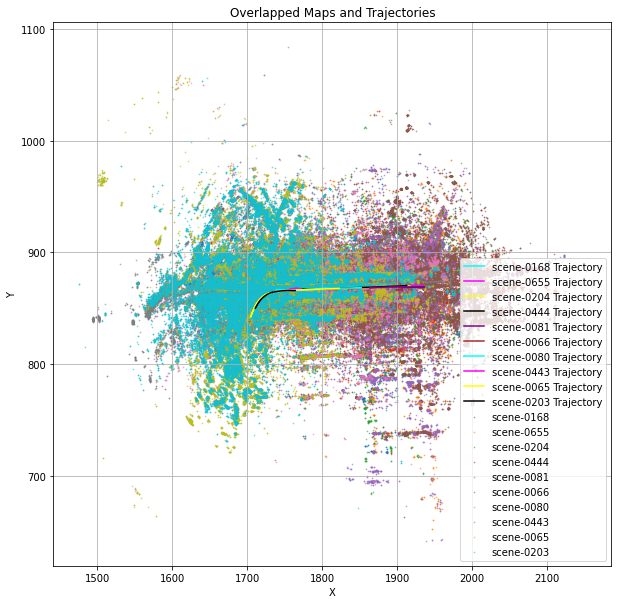

In [116]:
plot_maps(scene_maps=scene_maps, poses=scene_poses, zoom_level=-1)

In [117]:
filtered_scene_maps, filtered_scene_poses = create_filtered_maps(scene_poses, scene_pointclouds, threshold=1)

In [119]:
# plot_maps(filtered_scene_maps, filtered_scene_poses, zoom_level=7)

In [ ]:
filtered_radius_scene_maps, filtered_radius_scene_poses = create_filtered_maps_with_radius(scene_poses, scene_pointclouds, threshold=1, radius=100)
plot_maps(filtered_radius_scene_maps, filtered_radius_scene_poses, zoom_level=7)

### Using all maps

In [14]:
import concurrent.futures
import open3d as o3d

# Define a function for processing each row
def process_row(row):
    ref_scene_name = row['scene_name']
    ref_split = row['split']
    closest_scenes = row['closest_scenes_data']

    row_dls = {ref_scene_name: NuScenesMultipleRadarMultiSweeps(
        data_dir=data_dir,
        nusc=nuscenes_exp[ref_split],
        sequence=int(ref_scene_name.split("-")[-1]),
        sensors=sensors,
        nsweeps=num_sweeps,
        ref_frame=ref_frame,
        ref_sensor=ref_sensor,
        apply_dpr=apply_dpr,
        filter_points=filter_points,
        ransac_threshold=dpr_thresh
    )}

    for matched_scene, data in closest_scenes.items():
        row_dls[matched_scene] = NuScenesMultipleRadarMultiSweeps(
            data_dir=data_dir,
            nusc=nuscenes_exp[data['split']],
            sequence=int(matched_scene.split("-")[-1]),
            sensors=sensors,
            nsweeps=num_sweeps,
            ref_frame=ref_frame,
            ref_sensor=ref_sensor,
            apply_dpr=apply_dpr,
            filter_points=filter_points,
            ransac_threshold=dpr_thresh
        )

    # Process and downsample point clouds
    pointclouds = {name : [dl[i][0] for i in range(dl.num_readings)] for name, dl in row_dls.items()}
    downsampled_pointclouds = {
        name: [o3d.geometry.PointCloud(o3d.utility.Vector3dVector(pcl)).voxel_down_sample(voxel_size=0.05).points for pcl in pcls]
        for name, pcls in pointclouds.items()
    }
    
    # Consolidate downsampled point clouds
    scene_map = {name: np.vstack(pcls) for name, pcls in downsampled_pointclouds.items()}
    scene_pose = {name: dl.global_poses for name, dl in row_dls.items()}
    
    return downsampled_pointclouds, scene_map, scene_pose, row_dls

# Parallel processing using ThreadPoolExecutor
scene_pointclouds = {}
scene_maps = {}
scene_poses = {}
dataloaders = {}

with concurrent.futures.ThreadPoolExecutor() as executor:
    future_to_row = {executor.submit(process_row, row): i for i, row in sps_df.iterrows()}
    
    for future in concurrent.futures.as_completed(future_to_row):
        i = future_to_row[future]
        # try:
        pointclouds, scene_map, scene_pose, row_dls = future.result()
        scene_pointclouds.update(pointclouds)
        scene_maps.update(scene_map)
        scene_poses.update(scene_pose)
        dataloaders.update(row_dls)
    # except Exception as e:
        # print(f"Row {i} generated an exception: {e}")

In [17]:
pcd_dict = {key: convert_to_open3d_pcd(val) for key, val in scene_maps.items()}
pcd_merged = o3d.geometry.PointCloud()
for pcd in pcd_dict.values():
    pcd_merged += pcd

keys = list(pcd_dict.keys())
transforms = {}
for i in range(len(keys)):
    for j in range(i + 1, len(keys)):
        trans_key = f"{keys[i]}_{keys[j]}"
        transforms[trans_key] = align_pointclouds(pcd_dict[keys[i]], pcd_dict[keys[j]])

for key, trans in transforms.items():
    src, tgt = key.split('_')
    pcd_dict[src].transform(trans)

In [ ]:
overlapping_indices = find_overlapping_points(pcd_merged)

In [ ]:
cropped_pcd_dict = {}
cropped_indices_dict = {}
for key, pcd in pcd_dict.items():
    # original_indices = get_original_indices(pcd_merged, pcd, overlapping_indices)
    overlapping_points = np.asarray(pcd.points)[list(original_indices), :]
    cropped_pcd = o3d.geometry.PointCloud()
    cropped_pcd.points = o3d.utility.Vector3dVector(overlapping_points)
    cropped_pcd_dict[key] = cropped_pcd
    cropped_indices_dict[key] = list(original_indices)

cropped_scene_maps = {key: np.asarray(val.points) for key, val in cropped_pcd_dict.items()}
scene_maps = cropped_scene_maps

### Map Post-processing
Try to see if we can keep points that are in the FOV of all sequences

In [ ]:
# point_cloud_dict = scene_maps
# # point_cloud_dict = filtered_scene_maps
# # point_cloud_dict = filtered_radius_scene_maps

import numpy as np
import open3d as o3d

def convert_to_open3d_pcd(np_points):
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(np_points[:, :3])
    return pcd

def align_pointclouds(source, target):
    threshold = 0.5
    trans_init = np.eye(4)
    reg_p2p = o3d.pipelines.registration.registration_icp(
        source, target, threshold, trans_init,
        o3d.pipelines.registration.TransformationEstimationPointToPoint())
    return reg_p2p.transformation

def find_overlapping_points(pcd, threshold=0.1):
    pcd_tree = o3d.geometry.KDTreeFlann(pcd)
    overlapping_indices = set()
    points = np.asarray(pcd.points)
    for i, point in enumerate(points):
        [_, idx, _] = pcd_tree.search_radius_vector_3d(point, threshold)
        if len(idx) > 1:
            overlapping_indices.add(i)
    return overlapping_indices


# # Convert to Open3D point clouds
# pcd_dict = {key: convert_to_open3d_pcd(val) for key, val in point_cloud_dict.items()}

# # Merge point clouds
# pcd_merged = o3d.geometry.PointCloud()
# for pcd in pcd_dict.values():
#     pcd_merged += pcd

# # Downsample the merged point cloud (optional)
# # pcd_merged = pcd_merged.voxel_down_sample(voxel_size=0.1)

# # Align point clouds (pairwise alignment)
# keys = list(pcd_dict.keys())
# transforms = {}
# for i in range(len(keys)):
#     for j in range(i + 1, len(keys)):
#         trans_key = f"{keys[i]}_{keys[j]}"
#         transforms[trans_key] = align_pointclouds(pcd_dict[keys[i]], pcd_dict[keys[j]])

# # Apply transformations
# for key, trans in transforms.items():
#     src, tgt = key.split('_')
#     pcd_dict[src].transform(trans)

# # Find overlapping points in the merged point cloud
# overlapping_indices = find_overlapping_points(pcd_merged)

# # Map overlapping indices back to the original point clouds
# def get_original_indices(pcd_merged, pcd, overlapping_indices):
#     merged_points = np.asarray(pcd_merged.points)
#     pcd_points = np.asarray(pcd.points)
#     tree = o3d.geometry.KDTreeFlann(pcd)
#     original_indices = set()
#     for idx in overlapping_indices:
#         [_, idxs, _] = tree.search_radius_vector_3d(merged_points[idx], 0.1)
#         original_indices.update(idxs)
#     return original_indices

# # Crop individual point clouds to keep only overlapping points and track indices
# cropped_pcd_dict = {}
# cropped_indices_dict = {}
# for key, pcd in pcd_dict.items():
#     original_indices = get_original_indices(pcd_merged, pcd, overlapping_indices)
#     overlapping_points = np.asarray(pcd.points)[list(original_indices), :]
#     cropped_pcd = o3d.geometry.PointCloud()
#     cropped_pcd.points = o3d.utility.Vector3dVector(overlapping_points)
#     cropped_pcd_dict[key] = cropped_pcd
#     cropped_indices_dict[key] = list(original_indices)

# # Convert Open3D cropped point clouds back to numpy arrays
# cropped_scene_maps = {key: np.asarray(val.points) for key, val in cropped_pcd_dict.items()}

In [143]:
plot_maps(scene_maps, poses=scene_poses, zoom_level=-1)
# plot_maps(cropped_scene_maps, poses=filtered_scene_poses, zoom_level=7)

### Adding dynamic point filter for moving objects using LiDAR GT Detections

In [19]:
from scipy.spatial import KDTree

def transfer_labels(labels, radar_points):
    """
    Transfers labels from the labels array to the radar points based on the nearest neighbor search.

    Parameters:
    labels (np.ndarray): An Nx4 array where each row is (x, y, z, label).
    radar_points (np.ndarray): An Mx3 array where each row is (x, y, z).

    Returns:
    np.ndarray: An Mx4 array where each row is (x, y, z, label) with labels from the nearest point in the labels array.
    """
    # Extract the coordinates (x, y, z) from the labels array
    label_coords = labels[:, :3]

    print(np.unique(labels[:, 3], return_counts=True))

    # Build a KDTree for efficient nearest neighbor search
    tree = KDTree(label_coords)

    # Find the nearest neighbors for each radar point
    distances, indices = tree.query(radar_points)

    # Create an array to store the radar points with their corresponding labels
    radar_points_with_labels = np.zeros((radar_points.shape[0], radar_points.shape[1] + 1))

    # Copy the radar points to the new array
    radar_points_with_labels[:, :3] = radar_points

    # Assign the corresponding labels from the labels array
    radar_points_with_labels[:, 3] = labels[indices, 3]

    print(np.unique(radar_points_with_labels[:, 3], return_counts=True))


    return radar_points_with_labels

In [ ]:
# lidar_labelled_maps = {name: transfer_labels(np.load(f'{name}_lidar_labels.npy'), map[:,:3])   for name,map in cropped_scene_maps.items()}
# lidar_labels = {name: np.load(f'{name}_lidar_labels.npy') for name,map in cropped_scene_maps.items()}
# plot_maps(scene_maps=lidar_labelled_maps, poses=scene_poses, zoom_level=7)

### Building a prior for dynamic regions using individual scans of each sequence and populating a VoxelGrid

In [20]:
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

class VoxelGrid:
    def __init__(self, voxel_size, map_bounds):
        self.voxel_size = voxel_size
        self.map_bounds = map_bounds
        self.grid_shape = (
            int((map_bounds[1] - map_bounds[0]) / voxel_size),
            int((map_bounds[3] - map_bounds[2]) / voxel_size),
            int((map_bounds[5] - map_bounds[4]) / voxel_size)
        )
        self.voxel_counts = np.zeros(self.grid_shape)
    
    def point_to_voxel_index(self, point):
        ix = int((point[0] - self.map_bounds[0]) / self.voxel_size)
        iy = int((point[1] - self.map_bounds[2]) / self.voxel_size)
        iz = int((point[2] - self.map_bounds[4]) / self.voxel_size)
        return ix, iy, iz
    
    def update_with_scan(self, point_cloud):
        for point in point_cloud:
            ix, iy, iz = self.point_to_voxel_index(point)
            if 0 <= ix < self.grid_shape[0] and 0 <= iy < self.grid_shape[1] and 0 <= iz < self.grid_shape[2]:
                self.voxel_counts[ix, iy, iz] += 1
    
    def get_normalized_scores(self):
        max_count = np.max(self.voxel_counts)
        if max_count > 0:
            return 1 - (self.voxel_counts / max_count)  # Normalize to [0, 1]
        else:
            return self.voxel_counts
        
    def query_point_score(self, point):
        ix, iy, iz = self.point_to_voxel_index(point)
        if 0 <= ix < self.grid_shape[0] and 0 <= iy < self.grid_shape[1] and 0 <= iz < self.grid_shape[2]:
            normalized_scores = self.get_normalized_scores()
            return normalized_scores[ix, iy, iz]
        else:
            return None  # Point is outside the grid bounds
        
    def assign_scores_to_pointcloud(self, point_cloud):
        scores = []
        for point in point_cloud:
            score = self.query_point_score(point)
            scores.append(score)
        return np.hstack((point_cloud, np.array(scores).reshape(-1, 1)))


# Plot the probability map
def plot_voxel_grid(voxel_grid, probability_map, voxel_size, map_bounds):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    filled = np.argwhere(probability_map > 0)
    colors = plt.cm.get_cmap('RdYlGn')(probability_map[filled[:, 0], filled[:, 1], filled[:, 2]])
    
    for (ix, iy, iz), color in zip(filled, colors):
        x = ix * voxel_size + map_bounds[0]
        y = iy * voxel_size + map_bounds[2]
        z = iz * voxel_size + map_bounds[4]
        voxel = [
            [x, y, z],
            [x + voxel_size, y, z],
            [x + voxel_size, y + voxel_size, z],
            [x, y + voxel_size, z],
            [x, y, z + voxel_size],
            [x + voxel_size, y, z + voxel_size],
            [x + voxel_size, y + voxel_size, z + voxel_size],
            [x, y + voxel_size, z + voxel_size]
        ]
        ax.add_collection3d(Poly3DCollection([voxel], facecolors=color, edgecolor='k', linewidths=0.1, alpha=0.75))
    
    ax.set_xlim(map_bounds[0], map_bounds[1])
    ax.set_ylim(map_bounds[2], map_bounds[3])
    ax.set_zlim(map_bounds[4], map_bounds[5])
    plt.show()

# Plot the probability map using open3d
def plot_voxel_grid_open3d(normalized_scores, voxel_grid, voxel_size, map_bounds):
    points = []
    colors = []
    cmap = plt.cm.get_cmap('RdYlGn')

    filled = np.argwhere(normalized_scores > 0)
    
    for (ix, iy, iz) in filled:
        x = ix * voxel_size + map_bounds[0]
        y = iy * voxel_size + map_bounds[2]
        z = iz * voxel_size + map_bounds[4]
        if voxel_grid.voxel_counts[ix, iy, iz] < 1:
            color = [1, 1, 1]  # White for voxels with almost no points
        else:
            color = cmap(normalized_scores[ix, iy, iz])[:3]  # Get RGB color from colormap
        points.append([x, y, z])
        colors.append(color)

    point_cloud = o3d.geometry.PointCloud()
    point_cloud.points = o3d.utility.Vector3dVector(points)
    point_cloud.colors = o3d.utility.Vector3dVector(colors)

    voxel_grid = o3d.geometry.VoxelGrid.create_from_point_cloud(point_cloud, voxel_size)
    
    o3d.visualization.draw_geometries([voxel_grid])

    # Create colorbar
    fig, ax = plt.subplots(figsize=(6, 1))
    fig.subplots_adjust(bottom=0.5)

    norm = plt.Normalize(vmin=0, vmax=1)
    cb1 = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), cax=ax, orientation='horizontal')
    cb1.set_label('Static Score')

    plt.show()

## NOTE: VoxelGrid can work with local ego coordinates otherwise too big, better to use voxelhashmap
# # Define parameters
# voxel_size = 10  # Adjust based on your requirements
# map_bounds = [-250, 250, -250, 250, -10, 10]  # Example bounds, adjust as needed

# # Initialize voxel grid
# voxel_grid = VoxelGrid(voxel_size, map_bounds)

# # Process each radar scan
# for frame_id, point_cloud in radar_scans.items():
#     voxel_grid.update_with_scan(point_cloud)

# # Retrieve the final probabilities
# probability_map = voxel_grid.get_normalized_scores()

# plot_voxel_grid_open3d(probability_map, voxel_grid, voxel_size, map_bounds)
# # plot_voxel_grid(voxel_grid, probability_map, voxel_size, map_bounds)

In [21]:
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt
from collections import defaultdict

class VoxelHashMap:
    def __init__(self, voxel_size):
        self.voxel_size = voxel_size
        self.voxel_map = defaultdict(int)  # Using a default dictionary to store voxel counts

    def point_to_voxel_key(self, point):
        ix = int(np.floor(point[0] / self.voxel_size))
        iy = int(np.floor(point[1] / self.voxel_size))
        iz = int(np.floor(point[2] / self.voxel_size))
        return (ix, iy, iz)
    
    def update_with_scan(self, point_cloud):
        for point in point_cloud:
            voxel_key = self.point_to_voxel_key(point)
            self.voxel_map[voxel_key] += 1
    
    def get_normalized_scores(self):
        max_count = max(self.voxel_map.values()) if self.voxel_map else 1
        normalized_scores = {k: 1- (v / max_count) for k, v in self.voxel_map.items()}
        return normalized_scores

    def query_point_score(self, point):
        voxel_key = self.point_to_voxel_key(point)
        return self.voxel_map.get(voxel_key, 0) / max(self.voxel_map.values(), default=1)

    def assign_scores_to_pointcloud(self, point_cloud):
        scores = []
        for point in point_cloud:
            score = self.query_point_score(point)
            scores.append(1 - score) # Undo the 1-normalizd score for consisten visualization
        return np.hstack((point_cloud, np.array(scores).reshape(-1, 1)))


# Plot the probability map using open3d
def plot_voxel_hash_map_open3d(normalized_scores, voxel_hash_map, voxel_size):
    points = []
    colors = []
    cmap = plt.cm.get_cmap('RdYlGn')

    for (ix, iy, iz), score in normalized_scores.items():
        x = (ix + 0.5) * voxel_size  # Center of the voxel
        y = (iy + 0.5) * voxel_size
        z = (iz + 0.5) * voxel_size
        if voxel_hash_map.voxel_map[(ix, iy, iz)] < 1:
            color = [1, 1, 1]  # White for voxels with no points
        else:
            color = cmap(score)[:3]  # Get RGB color from colormap
        points.append([x, y, z])
        colors.append(color)

    point_cloud = o3d.geometry.PointCloud()
    point_cloud.points = o3d.utility.Vector3dVector(points)
    point_cloud.colors = o3d.utility.Vector3dVector(colors)

    voxel_grid = o3d.geometry.VoxelGrid.create_from_point_cloud_within_bounds(point_cloud, voxel_size, point_cloud.get_min_bound(), point_cloud.get_max_bound())
    
    o3d.visualization.draw_geometries([voxel_grid])

    # Create colorbar
    fig, ax = plt.subplots(figsize=(6, 1))
    fig.subplots_adjust(bottom=0.5)

    norm = plt.Normalize(vmin=0, vmax=1)
    cb1 = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), cax=ax, orientation='horizontal')
    cb1.set_label('Static Score')

    plt.show()


In [22]:

## Create Dataloader for each scene in a record
voxel_prior_dataloaders = {ref_scene_name : NuScenesMultipleRadarMultiSweeps(
    data_dir=data_dir,
    nusc=nuscenes_exp[ref_split],
    sequence=int(ref_scene_name.split("-")[-1]),
    sensors=sensors,
    nsweeps=num_sweeps,
    ref_frame='global',
    ref_sensor=ref_sensor,
    apply_dpr=False,
    filter_points=False,
    ransac_threshold=dpr_thresh

)}

for matched_scene, data in closest_scenes.items():
    voxel_prior_dataloaders[matched_scene] = NuScenesMultipleRadarMultiSweeps(
    data_dir=data_dir,
    nusc=nuscenes_exp[data['split']],
    sequence=int(matched_scene.split("-")[-1]),
    sensors=sensors,
    nsweeps=num_sweeps,
    ref_frame='global',
    ref_sensor=ref_sensor,
    apply_dpr=False,
    filter_points=False,
    ransac_threshold=dpr_thresh
)


# scene_scans = {name: {i:dataloader[i][0][:,:3] for i in range(len(dataloader))} for name,dataloader in voxel_prior_dataloaders.items()}
scene_scans = {name: {i:dataloader[i][0][:,:3] for i in range(len(dataloader))} for name,dataloader in dataloaders.items()}

In [23]:
voxel_size = 0.5 # Size of region in the map we want to track in meters
def create_voxel_map(radar_scans):
    # Initialize voxel hash map
    voxel_hash_map = VoxelHashMap(voxel_size)

    # Process each radar scan
    for frame_id, point_cloud in radar_scans.items():
        voxel_hash_map.update_with_scan(point_cloud)
    return voxel_hash_map

def plot_voxel_map(voxel_hash_map):
    # Retrieve the normalized scores
    normalized_scores = voxel_hash_map.get_normalized_scores()

    plot_voxel_hash_map_open3d(normalized_scores, voxel_hash_map, voxel_size)

In [24]:
scene_voxel_maps = {name : create_voxel_map(scans) for name,scans in scene_scans.items()}

In [ ]:
plot_voxel_map(scene_voxel_maps[ref_scene_name])

In [ ]:
# labelled_scan =  voxel_hash_map.assign_scores_to_pointcloud(dataloader[10][0][: ,:3])
# labelled_map =  voxel_hash_map.assign_scores_to_pointcloud(scene_maps['scene-0172'][: ,:3])
# sps_labeler.plot_labeled_map_bev(labelled_scan, size=3)

### Octomaps

In [ ]:
def build_octomap(dl, resolution=0.1):
    # Initialize the OctoMap with the specified resolution
    poses = dl.global_poses
    num_readings = dl.num_readings
    octree = octomap.OcTree(resolution)
    
    # Define occupancy thresholds
    # prob_hit = 0.7  # Probability that a voxel is occupied when a point is observed
    # prob_miss = 0.4  # Probability that a voxel is free when a ray passes through
    # clamping_thres_min = 0.12  # Minimum probability value for occupancy
    # clamping_thres_max = 0.97  # Maximum probability value for occupancy

    # octree.setProbHit(prob_hit)
    # octree.setProbMiss(prob_miss)
    # octree.setClampingThresMin(clamping_thres_min)
    # octree.setClampingThresMax(clamping_thres_max)

    for i in tqdm(range(num_readings)):
        pointcloud = dl[i][0]
        pose = poses[i]
        sensor_origin = pose[:3, 3]
        octree.insertPointCloud(pointcloud, sensor_origin)

    # occupied, empty = octree.extractPointCloud()
    return octree



# def build_octomap(map, resolution=0.1):
#     tree = octomap.OcTree(resolution)
#     for point in map:
#         x,y,z = point[:3]
#         tree.updateNode((x,y,z), True)
#     tree.updateInnerOccupancy()
#     occupied, free = tree.extractPointCloud()

#     return tree, occupied
    

In [ ]:
def plot_occupancy_score_dist(omap):
    occupancy_dist = []
    for node in omap.begin_leafs():
        x,y,z = node.getCoordinate()
        occupancy = node.getOccupancy()
        occupancy_dist.append(occupancy)
        # print(f"Node at ({x:0.2f}, {y:0.2f}, {z:0.2f}) has occupancy probability {occupancy:0.2f}")

    plt.figure(figsize=(12, 6))
    plt.hist(occupancy_dist, bins=30, color='skyblue', edgecolor='black')
    plt.title('Distribution of Occupancy Values')
    plt.xlabel('Occupancy Score')
    plt.ylabel('Frequency')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

In [ ]:
def extract_high_occupancy_points(octree, threshold):
    """
    Extract points from the OctoMap with occupancy greater than the specified threshold.

    Args:
        octomap_file (str): Path to the OctoMap file.
        threshold (float): The occupancy probability threshold.

    Returns:
        numpy.ndarray: The extracted point cloud as an array of shape (N, 3).
    """
    # List to store the filtered points
    points = []

    # Iterate over all leaf nodes in the OctoMap
    for node in octree.begin_leafs():
        occupancy = node.getOccupancy()
        if occupancy > threshold:
            x, y, z = node.getCoordinate()
            points.append([x, y, z])

    # Convert the list to a numpy array
    pointcloud = np.array(points)
    return pointcloud

In [ ]:
scene_octomaps = {name: build_octomap(dl) for name,dl in dataloaders.items()}
# scene_octomaps = {name: build_octomap(map) for name,map in scene_maps.items()}

100%|██████████| 76/76 [00:21<00:00,  3.48it/s]


In [ ]:
plot_occupancy_score_dist(scene_octomaps[ref_scene_name])

In [ ]:
OCCUPANCY_THRESHOLD = 0.5
# scene_maps_high_occ = {name: extract_high_occupancy_points(omap, OCCUPANCY_THRESHOLD) for name,omap in scene_octomaps.items()}

In [ ]:
# plot_maps(scene_maps_high_occ, scene_poses, zoom_level=7)

In [ ]:
## Test if occlusion check works
sample_omap = scene_octomaps[ref_scene_name]
sample_scan = dataloaders[ref_scene_name][10][0]
sample_point = sample_scan[0]

node = sample_omap.search(sample_point)
if node is not None:
    occupied = sample_omap.isNodeOccupied(node)
    print(occupied)
else:
    print("Point not found in Octomap")

In [ ]:
for name, omap in scene_octomaps.items():
    print(name, ref_scene_name)
    map_ = scene_maps[name]
    occupancy_dist = []
    misses = 0
    for p in tqdm(desc=f'Processing Scene: {name}', iterable=map_[:,:3]):
        try: 
            occupancy_dist.append(omap.isNodeOccupied(omap.search(p)))
        except octomap.NullPointerException:
            misses+=1
    print(f"{misses} points could not be found in the map")
    # occupancy_dist = [omap.isNodeOccupied(omap.search(p[:3])) for p in map_]
    ## Free, Occupied, Total
    print(f"Occupancy Dist for Map: {name} | Total: {len(occupancy_dist)} Occupied:{sum(map(int, occupancy_dist))} Free: {len(occupancy_dist) - sum(map(int, occupancy_dist))}")

In [ ]:
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable, get_cmap
# Retrieve all occupied nodes and their occupancy scores
occupied_nodes = []
empty_nodes = []
occupancy_scores = []
octree = scene_octomaps[ref_scene_name]

# Iterate through all leaf nodes in the octree
for node in octree.begin_leafs():
    occupancy = node.getOccupancy()
    x, y, z = node.getCoordinate()
    if occupancy > 0.5:
        occupied_nodes.append([x, y, z])
        occupancy_scores.append(occupancy)
    else:
        empty_nodes.append([x, y, z])
        

# Convert to numpy array for easier handling
occupied_nodes = np.array(occupied_nodes)
empty_nodes = np.array(empty_nodes)
occupancy_scores = np.array(occupancy_scores)


In [ ]:
# Normalize occupancy scores for colormap
norm = Normalize(vmin=occupancy_scores.min(), vmax=occupancy_scores.max())
cmap = get_cmap('RdYlGn')  # Red-Yellow-Green colormap
colors = cmap(norm(occupancy_scores))

# Create Open3D point cloud
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(occupied_nodes)
pcd.colors = o3d.utility.Vector3dVector(colors[:, :3])  # Open3D uses RGB colors
resolution = 0.5

empty_pcd = o3d.geometry.PointCloud()
empty_pcd.points = o3d.utility.Vector3dVector(empty_nodes)

# Create voxel grids for occupied and empty spaces
occupied_voxels = o3d.geometry.VoxelGrid.create_from_point_cloud(
  pcd, voxel_size=resolution
)
empty_voxels = o3d.geometry.VoxelGrid.create_from_point_cloud(
  empty_pcd, voxel_size=resolution
)

# Set colors for the voxel grids
# occupied_voxels.paint_uniform_color([1.0, 0, 0])
# empty_voxels.paint_uniform_color([0.5, 0.5, 0.5])

# Create a visualizer
vis = o3d.visualization.Visualizer()
vis.create_window()

# Add geometries to the visualizer
# vis.add_geometry(pcd)
vis.add_geometry(occupied_voxels)
vis.add_geometry(empty_voxels)

# Run the visualizer
vis.run()
vis.destroy_window()

### Stable-Point Labeler

In [ ]:
class AutoLabeler:
    def __init__(self,
                 scene_maps, 
                 ref_map_id, 
                 scene_octomaps,
                 scene_poses, 
                 lidar_labels=None, 
                 dynamic_priors=None, 
                 use_octomaps=True, 
                 search_in_radius=False,
                 downsample=False, 
                 radius=1.5,
                 fallback_map_radius=100,
                 map_bounds_radius=None,
                 voxel_size=0.5):
        
        self.use_octomaps = use_octomaps
        self.maps = scene_maps
        self.octomaps = scene_octomaps
        self.lidar_labels = lidar_labels
        self.dynamic_priors = dynamic_priors
        self.search_in_radius = search_in_radius
        self.radius = radius
        self.fallback_map_radius = fallback_map_radius
        self.scene_poses = scene_poses
        self.occluded_point = -1

        if downsample:
            self.maps = {}
            for name,map in scene_maps.items():
                # Create an Open3D point cloud object
                point_cloud = o3d.geometry.PointCloud()
                point_cloud.points = o3d.utility.Vector3dVector(map[:, :3])
                
                # Downsample the point cloud
                ref_map_sampled = point_cloud.voxel_down_sample(voxel_size=voxel_size)
                map_points = np.asarray(ref_map_sampled.points)
                self.maps[name] = map_points

        self.ref_map_id = ref_map_id
        self.maps_ids = list(self.maps.keys())
        self.labelled_maps = {}

        if self.lidar_labels is not None:
            self.lidar_labeled_scene_maps = {}
            for name in self.maps:
                labels = self.lidar_labels[name]
                radar_map = self.maps[name]
                new_map = transfer_labels(labels, radar_map[:, :3])
                self.lidar_labeled_scene_maps[name] = new_map
        
        self.map_centers = {name: np.mean(map[:,:3], axis=0) for name,map in self.maps.items()}
        if map_bounds_radius is None:
            self.map_bounds_radius = self.calculate_map_bounds_radius(buffer=25)
        else:
            self.map_bounds_radius = map_bounds_radius # meters

    def adjust_stability_scores(self, labeled_map, map_id):
        center = self.map_centers[map_id]
        radius = self.map_bounds_radius
        for i, point in enumerate(labeled_map):
            distance = np.linalg.norm(point[:3] - center)
            if distance > radius:
                labeled_map[i, -1] = 0.5 + 0.5 * (labeled_map[i, -1] - 0.5)  # Move score closer to 0.5
        return labeled_map

    def calculate_map_bounds_radius(self, buffer=0):
        *poses, = self.scene_poses.values()
        all_poses = []
        [all_poses.extend(p) for p in poses]
        all_poses = np.stack(all_poses)[:,:3,3]
        
        center = np.mean(all_poses, axis=0)
        max_distance = np.max(np.linalg.norm(all_poses - center, axis=1)) + buffer
        if max_distance < self.fallback_map_radius / 2:  # Example threshold, adjust as needed
            max_distance = self.fallback_map_radius
        return max_distance

    def label_maps(self):
        for map_id, ref_map in self.maps.items():
            max_features = []
            print(f"Extracting features for {map_id}...")

            for point in tqdm(ref_map):
                # Check if the point is within the map bounds radius
                # if np.linalg.norm(point[:3] - self.map_centers[map_id]) > self.map_bounds_radius[map_id]:
                #     max_features.append(0.5)  # Assign stability score of 0.5 if outside bounds
                #     continue

                dis = []
                for query_map in self.maps_ids:
                    if query_map == map_id or len(self.maps[query_map]) < 1:
                        continue
                    occluded = self.is_point_occluded(point, query_map) if self.use_octomaps else False
                    if not occluded:
                        if self.search_in_radius:
                            d_radius = self.get_points_within_radius(point, self.maps[query_map], radius=self.radius)
                            dis.extend(d_radius)
                        else:
                            d = self.get_distance_to_closest_point(point, self.maps[query_map])
                            dis.append(d)
                    else:
                        dis.append(self.occluded_point)
                
                if len(dis):
                    max_dis = max(dis)
                else:
                    max_dis = np.inf # No correspondence found

                if max_dis != self.occluded_point:
                    max_dis = 1 - np.exp(-max_dis * (max_dis / 100))
            
                max_features.append(max_dis)

            labeled_map = np.hstack((ref_map, np.array(max_features).reshape(-1, 1)))
            labeled_map[:, -1] = 1 - labeled_map[:, -1]  # Using 1 for stability

            if self.lidar_labels is not None:
                labeled_map[:, -1] = labeled_map[:, -1] * self.lidar_labeled_scene_maps[map_id][:, -1]  # combine lidar proxy labels
            
            if self.dynamic_priors:
                voxel_hash_map = self.dynamic_priors[map_id]
                scan_dynamic_scores = voxel_hash_map.assign_scores_to_pointcloud(labeled_map[:, :3])
                labeled_map[:, -1] *= scan_dynamic_scores[:, -1]

            labeled_map[:, -1] = np.clip(labeled_map[:, -1], 0, 1)

            # labeled_map = self.adjust_stability_scores(labeled_map, map_id)

            self.labelled_maps[map_id] = labeled_map
        self.labeled_environment_map = np.vstack([m for m in self.labelled_maps.values()])


    def get_distance_to_closest_point(self, point, points, euclidean_weight=1, rcs_weight=0):
        # Extract the RCS value of the point
        if rcs_weight > 0:
            point_rcs = point[3]  # Assuming the 4th column (index 3) is RCS
            # Calculate the differences in RCS values
            rcs_differences = np.abs(points[:, 3] - point_rcs)
        else:
            rcs_differences = 0

        # Calculate Euclidean distances
        euclidean_distances = np.linalg.norm(points[:, :3] - point[:3], axis=1)

        # Combine Euclidean distance and RCS difference to form a composite distance
        # Here we use adjustable weights for both distance and RCS difference
        combined_distances = np.sqrt((euclidean_weight * euclidean_distances)**2 + (rcs_weight * rcs_differences)**2)
        return np.min(combined_distances)
    

    def get_points_within_radius(self, point, points, radius=1, euclidean_weight=1, rcs_weight=0):
        """
        Get all points within a specified radius from the given point.

        Parameters:
        - point: The reference point.
        - points: An array of points to check against.
        - radius: The radius within which to find points (default is 0.5 meters).
        - euclidean_weight: The weight for the Euclidean distance.
        - rcs_weight: The weight for the RCS difference.

        Returns:
        - A list of points within the specified radius.
        """
        # Extract the RCS value of the point
        if rcs_weight > 0:
            point_rcs = point[3]  # Assuming the 4th column (index 3) is RCS
            # Calculate the differences in RCS values
            rcs_differences = np.abs(points[:, 3] - point_rcs)
        else:
            rcs_differences = np.zeros(len(points))  # Ensure the array shape matches

        # Calculate Euclidean distances
        euclidean_distances = np.linalg.norm(points[:, :3] - point[:3], axis=1)

        # Combine Euclidean distance and RCS difference to form a composite distance
        combined_distances = np.sqrt((euclidean_weight * euclidean_distances)**2 + (rcs_weight * rcs_differences)**2)

        # Find indices of points within the specified radius
        within_radius_indices = np.where(combined_distances <= radius)[0]

        # Get the points within the specified radius
        points_within_radius = points[within_radius_indices]

        return combined_distances[within_radius_indices].tolist()


    def is_point_occluded(self, point, map_id):
        # Placeholder function to check if a point is occluded using octomap
        # Replace with actual occlusion check logic
        if self.use_octomaps and map_id in self.octomaps:
            octree = self.octomaps[map_id]
            node = octree.search(point)
            try:
                if node and octree.isNodeOccupied(node):
                    return True
            except octomap.NullPointerException:
                return False # NOTE: If a search fails, then return occluded
        return False

    def label_scan(self, scan, map_id=None):
        if map_id is None:
            print(f"Registering scan to combined environment map...")
            target_map = self.labeled_environment_map
        else:
            print(f"Registering scan to {map_id} map...")
            target_map = self.labelled_maps[map_id]

        transformation = self.icp_registration(scan[:, :3], target_map[:, :3])
        scan[:, :3] = self.apply_transformation(scan[:, :3], transformation)

        scan_labels = []
        labeled_map_points = target_map[:, :3]
        labeled_map_labels = target_map[:, -1]

        for point in tqdm(scan[:, :3]):
            # Check if the point is within the map bounds radius
            # if map_id is not None and np.linalg.norm(point[:3] - self.map_centers[map_id]) > self.map_bounds_radius[map_id]:
            #     scan_labels.append(0.5)  # Assign stability score of 0.5 if outside bounds
            #     continue

            distances = np.linalg.norm(labeled_map_points - point, axis=1)
            closest_point_idx = np.argmin(distances)
            closest_distance = distances[closest_point_idx]

            if closest_distance <= self.radius:
                scan_labels.append(labeled_map_labels[closest_point_idx])
            else:
                # scan_labels.append(np.inf)  # Assign stability score of inf if no correspondence within radius
                scan_labels.append(0.5)  # Assign stability score of 0.5 if no correspondence within radius

        scan_labels = np.array(scan_labels)
        labeled_scan = np.hstack((scan, scan_labels.reshape(-1, 1)))
        # labeled_scan = self.adjust_stability_scores(labeled_scan, map_id)
        return labeled_scan
        

    def icp_registration(self, source_points, target_points):
        source = o3d.geometry.PointCloud()
        target = o3d.geometry.PointCloud()
        source.points = o3d.utility.Vector3dVector(source_points)
        target.points = o3d.utility.Vector3dVector(target_points)

        threshold = 0.02  # Distance threshold for ICP
        trans_init = np.identity(4)
        reg_p2p = o3d.pipelines.registration.registration_icp(
            source, target, threshold, trans_init,
            o3d.pipelines.registration.TransformationEstimationPointToPoint())
        return reg_p2p.transformation

    def apply_transformation(self, points, transformation):
        points_hom = np.hstack((points, np.ones((points.shape[0], 1))))
        transformed_points_hom = points_hom.dot(transformation.T)
        return transformed_points_hom[:, :3]

    def plot_bev(self, points, labels, title="Bird's Eye View", size=1):
        plt.figure(figsize=(10, 10))
        plt.scatter(points[:, 0], points[:, 1], c=labels, cmap='RdYlGn', s=size)
        plt.colorbar(label='Stability')
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.title(title)
        plt.show()

    def plot_labeled_map_bev(self, map_id, size=1, plot_radius=False):
        labeled_map = self.labelled_maps[map_id]
        points = labeled_map[:, :3]
        labels = labeled_map[:, -1]
        center = self.map_centers[map_id]
        radius = self.map_bounds_radius
        
        plt.figure(figsize=(10, 10))
        plt.scatter(points[:, 0], points[:, 1], c=labels, cmap='RdYlGn', s=size)
        if plot_radius:
            circle = plt.Circle((center[0], center[1]), radius, color='blue', fill=False, linewidth=2)
            plt.gca().add_artist(circle)
        plt.colorbar(label='Stability')
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.title(f"BEV of Labeled Map {map_id}")
        plt.show()

    def plot_labeled_scan_bev(self, labeled_scan, size=1):
        points = labeled_scan[:, :3]
        labels = labeled_scan[:, -1]
        plt.figure(figsize=(10, 10))
        plt.scatter(points[:, 0], points[:, 1], c=labels, cmap='RdYlGn', s=size)
        
        plt.colorbar(label='Stability')
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.title("Labeled scan and map")

    def save_bev_plot(self, map_id, save_path, title="Labelled Map Bird's Eye View", size=1):
        labeled_map = self.labelled_maps[map_id]
        points = labeled_map[:, :2]
        labels = labeled_map[:, -1]
        center = self.map_centers[map_id]
        radius = self.map_bounds_radius
        
        plt.figure(figsize=(10, 10))
        plt.scatter(points[:, 0], points[:, 1], c=labels, cmap='RdYlGn', s=size)
        # circle = plt.Circle((center[0], center[1]), radius, color='blue', fill=False, linewidth=2)
        # plt.gca().add_artist(circle)
        plt.colorbar(label='Stability')
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.title(title)
        plt.savefig(save_path)
        plt.close()




In [ ]:
def load_octomap(path):
    with open(path, 'rb') as f:
        return octomap.OcTree(f.read())
    
def save_octomap(path, tree):
    with open(path, 'wb') as f:
        f.write(tree.writeBinary())

In [ ]:
sps_labeler = AutoLabeler(
    scene_maps=scene_maps, ref_map_id=ref_scene_name, scene_poses=scene_poses,
    scene_octomaps=scene_octomaps, lidar_labels=None,
    dynamic_priors=scene_voxel_maps,  use_octomaps=True, search_in_radius=True,
    downsample=True, voxel_size=0.1)

In [ ]:
sps_labeler.label_maps()

Extracting features for scene-0168...


100%|██████████| 1216/1216 [00:07<00:00, 156.27it/s]


Extracting features for scene-0655...


100%|██████████| 12014/12014 [01:15<00:00, 159.80it/s]


Extracting features for scene-0204...


100%|██████████| 9084/9084 [00:55<00:00, 163.96it/s]


Extracting features for scene-0444...


100%|██████████| 18330/18330 [01:45<00:00, 173.15it/s]


Extracting features for scene-0081...


100%|██████████| 10171/10171 [01:02<00:00, 163.15it/s]


Extracting features for scene-0066...


100%|██████████| 4686/4686 [00:30<00:00, 156.14it/s]


Extracting features for scene-0080...


100%|██████████| 27900/27900 [02:39<00:00, 175.41it/s]


Extracting features for scene-0443...


100%|██████████| 21963/21963 [02:08<00:00, 171.37it/s]


Extracting features for scene-0065...


100%|██████████| 46348/46348 [03:53<00:00, 198.76it/s]


Extracting features for scene-0203...


100%|██████████| 41366/41366 [03:19<00:00, 206.84it/s]


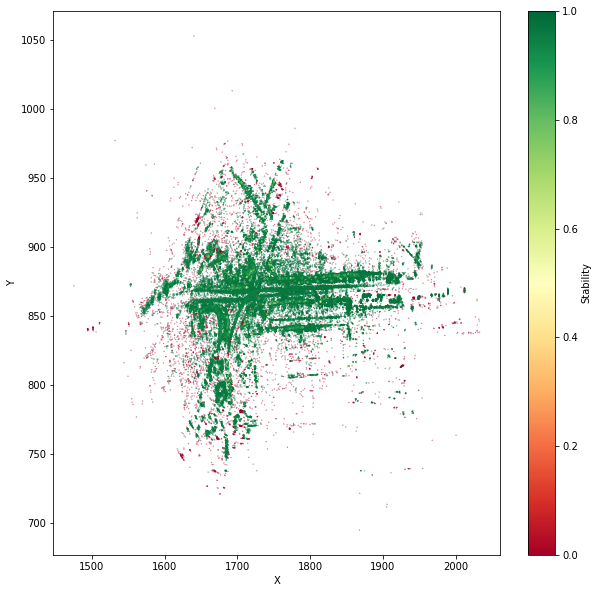

In [139]:
labeled_map = sps_labeler.labeled_environment_map
points = labeled_map[:, :3]
labels = labeled_map[:, -1]

plt.figure(figsize=(10, 10))
plt.scatter(points[:, 0], points[:, 1], c=labels, cmap='RdYlGn', s=0.05)
plt.colorbar(label='Stability')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

In [ ]:
sps_labeler.map_bounds_radius

In [ ]:
for name in sps_labeler.maps_ids:
    sps_labeler.plot_labeled_map_bev(map_id=name)

In [ ]:
labels_dist = sps_labeler.labelled_maps[ref_scene_name][:,-1]
plt.figure(figsize=(12, 6))
plt.hist(labels_dist, bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Assigned Labels for a Scene')
plt.xlabel('Stability Score')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
sample_scan = dataloaders[ref_scene_name][10][0]
sample_scan.shape

In [ ]:
labelled_scan = sps_labeler.label_scan(sample_scan, map_id=ref_scene_name)

In [ ]:
labels_dist = labelled_scan[:,-1]
plt.figure(figsize=(12, 6))
plt.hist(labels_dist, bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Assigned Labels for a Scan')
plt.xlabel('Stability Score')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
sps_labeler.plot_labeled_scan_bev(labelled_scan)

In [ ]:
labels_dir = "labelled_maps/dynamic_prior_5sweep_radius_corr_fixed_dpr/"
from pathlib import Path
Path(labels_dir).mkdir(parents=True, exist_ok=True)

In [ ]:
for map_name, lmap in sps_labeler.labelled_maps.items():
    points = lmap[:, :3]
    stable_probs = lmap[:,-1]
    filename = f"{labels_dir}/{map_name}.asc"
    np.savetxt(filename,
               np.hstack([points,stable_probs.reshape(-1,1)]),
               fmt='%.6f', delimiter=' ',
               header='x y z stable_prob',
               comments='')    

In [ ]:
{name: dl.scene['first_sample_token'] for name,dl in dataloaders.items()}

In [ ]:
ref_split, data['split']

In [ ]:
df = pd.read_json("/home/umair/workspace/repos/radar_auto_labeler/nuscenes_scenes_df.json")
df = df[df['closest_scenes'].apply(lambda x: len(x) > 2)]

In [ ]:
df